# Sentinel-1 Level 0 Data Decoding Example

Sentinel-1 is a Synthetic Aperture Radar satellite constellation operated by the European Space Agency (ESA). ESA publish several types of product associated with each data acquisition. Level 1 and Level 2 data files consist of various types of processed SAR images, but the raw packetized data downlinked to the ground is also available in the form of Level 0 products.

ESA also publish details of the [image formation algorithm used to generate Level 1 products](https://sentinels.copernicus.eu/web/sentinel/user-guides/document-library/-/asset_publisher/xlslt4309D5h/content/id/4629294?_com_liferay_asset_publisher_web_portlet_AssetPublisherPortlet_INSTANCE_xlslt4309D5h_redirect=https%3A%2F%2Fsentinels.copernicus.eu%2Fweb%2Fsentinel%2Fuser-guides%2Fdocument-library%3Fp_p_id%3Dcom_liferay_asset_publisher_web_portlet_AssetPublisherPortlet_INSTANCE_xlslt4309D5h%26p_p_lifecycle%3D0%26p_p_state%3Dnormal%26p_p_mode%3Dview%26_com_liferay_asset_publisher_web_portlet_AssetPublisherPortlet_INSTANCE_xlslt4309D5h_cur%3D2%26_com_liferay_asset_publisher_web_portlet_AssetPublisherPortlet_INSTANCE_xlslt4309D5h_delta%3D10%26p_r_p_resetCur%3Dfalse%26_com_liferay_asset_publisher_web_portlet_AssetPublisherPortlet_INSTANCE_xlslt4309D5h_assetEntryId%3D4629294) and [structure of Sentinel-1 data packets](https://sentinels.copernicus.eu/web/sentinel/user-guides/document-library/-/asset_publisher/xlslt4309D5h/content/id/3120468?_com_liferay_asset_publisher_web_portlet_AssetPublisherPortlet_INSTANCE_xlslt4309D5h_redirect=https%3A%2F%2Fsentinels.copernicus.eu%2Fweb%2Fsentinel%2Fuser-guides%2Fdocument-library%3Fp_p_id%3Dcom_liferay_asset_publisher_web_portlet_AssetPublisherPortlet_INSTANCE_xlslt4309D5h%26p_p_lifecycle%3D0%26p_p_state%3Dnormal%26p_p_mode%3Dview%26_com_liferay_asset_publisher_web_portlet_AssetPublisherPortlet_INSTANCE_xlslt4309D5h_cur%3D13%26_com_liferay_asset_publisher_web_portlet_AssetPublisherPortlet_INSTANCE_xlslt4309D5h_delta%3D10%26p_r_p_resetCur%3Dfalse%26_com_liferay_asset_publisher_web_portlet_AssetPublisherPortlet_INSTANCE_xlslt4309D5h_assetEntryId%3D3120468) in their [document library](https://sentinels.copernicus.eu/web/sentinel/user-guides/document-library).

This notebook demonstrates data extraction from Level 0 products using the Sentinel1Decoder Python code at https://github.com/Rich-Hall/sentinel1decoder. An example implementation of the range-Doppler algorithm is also provided to demonstrate image formation from this data.

## 1 - Imports and setup

In [1]:
import sentinel1decoder
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import gc
from matplotlib import colors
from scipy.interpolate import interp1d
from scipy.fft import fft, ifft, fftshift, ifftshift

In [2]:
filepath = "./data/sao_paulo/"
filename = "s1a-s6-raw-s-vv-20251226t214356-20251226t214427-062491-07d496.dat"

inputfile = filepath+filename

l0file = sentinel1decoder.Level0File(inputfile)

## 2 - Extract File Metadata

Sentinel-1 level 0 data files consist of the raw packetized data sent to the ground. One packet typically consists of the radar instrument output associated with one radar echo, so a single file typically consists of many thousands of packets. Packets may also consist of other types of data e.g. background noise measurements for instrument calibration.

We are working with data acquired in stripmap mode over Sao Paulo and the nearby port of Santos, Brazil. Stripmap data is mainly used to monitor small islands, so is relatively infrequently used. However, it is relatively simple compared to Interferometric Wide Swath mode, the main acquisiton mode used over land, and therefore makes our task of image formation much simpler!

Initially we're going to pull the metadata from each packet and output to a Pandas dataframe to examine the file contents. Producing an image from the entirity of the data found in a single file would take a long time and require a lot of memory, so we're aiming to produce an image from just a subset of this data.

In [3]:
l0file.packet_metadata

Packet Version Number  Packet Type  \
Azimuth Block Number Packet Number                                       
1                    0                                  0            0   
                     1                                  0            0   
                     2                                  0            0   
                     3                                  0            0   
                     4                                  0            0   
...                                                   ...          ...   
16                   50701                              0            0   
                     50702                              0            0   
                     50703                              0            0   
                     50704                              0            0   
                     50705                              0            0   

                                    Secondary Header Flag  PID  PCAT  \
Azimuth Block Number Packet Number                                     
1                    0                                  1   65    12   
                     1                                  1   65    12   
                     2                                  1   65    12   
                     3                                  1   65    12   
                     4                                  1   65    12   
...                                                   ...  ...   ...   
16                   50701                              1   65    12   
                     50702                              1   65    12   
                     50703                              1   65    12   
                     50704                              1   65    12   
                     50705                              1   65    12   

                                    Sequence Flags  Packet Sequence Count  \
Azimuth Block Number Packet Number                                          
1                    0                           3                      0   
                     1                           3                      1   
                     2                           3                      2   
                     3                           3                      3   
                     4                           3                      4   
...                                            ...                    ...   
16                   50701                       3                   1549   
                     50702                       3                   1550   
                     50703                       3                   1551   
                     50704                       3                   1552   
                     50705                       3                   1553   

                                    Packet Data Length  Coarse Time  \
Azimuth Block Number Packet Number                                    
1                    0                           25086   1450820654   
                     1                           25086   1450820654   
                     2                           25086   1450820654   
                     3                           25086   1450820654   
                     4                           25086   1450820654   
...                                                ...          ...   
16                   50701                       25126   1450820685   
                     50702                       25126   1450820685   
                     50703                       25126   1450820685   
                     50704                       25126   1450820685   
                     50705                       25126   1450820685   

                                    Fine Time  ...       SWL  SAS SSB Flag  \
Azimuth Block Number Packet Number             ...                           
1                    0               0.593239  ...  0.

The satellite ephemeris data is sub-commutated across multiple packets due to its relatively low update rate, so we need to perform an extra step to extract this information.

In [4]:
l0file.ephemeris

X-axis position ECEF  Y-axis position ECEF  Z-axis position ECEF  \
0            3.956337e+06         -5.019184e+06         -3.046799e+06   
1            3.956337e+06         -5.019184e+06         -3.046799e+06   
2            3.956337e+06         -5.019184e+06         -3.046799e+06   
3            3.956337e+06         -5.019184e+06         -3.046799e+06   
4            3.956337e+06         -5.019184e+06         -3.046799e+06   
..                    ...                   ...                   ...   
757          3.974394e+06         -5.122282e+06         -2.844619e+06   
758          3.974394e+06         -5.122282e+06         -2.844619e+06   
759          3.974394e+06         -5.122282e+06         -2.844619e+06   
760          3.974394e+06         -5.122282e+06         -2.844619e+06   
761          3.974394e+06         -5.122282e+06         -2.844619e+06   

     X-axis velocity ECEF  Y-axis velocity ECEF  Z-axis velocity ECEF  \
0              675.942993          -3520.009277           6689.019531   
1              675.942993          -3520.009277           6689.019531   
2              675.942993          -3520.009277           6689.019531   
3              675.942993          -3520.009277           6689.019531   
4              675.942993          -3520.009277           6689.019531   
..                    ...                   ...                   ...   
757            527.892090          -3352.554443           6788.559570   
758            527.892090          -3352.554443           6788.559570   
759            527.892090          -3352.554443           6788.559570   
760            527.892090          -3352.554443           6788.559570   
761            527.892090          -3352.554443           6788.559570   

     POD Solution Data Timestamp  Q0 Attitude Quaternion  \
0                   1.450821e+09                0.843701   
1                   1.450821e+09                0.843701   
2                   1.450821e+09                0.843701   
3                   1.450821e+09                0.843701   
4                   1.450821e+09                0.843701   
..                           ...                     ...   
757                 1.450821e+09                0.835609   
758                 1.450821e+09                0.835609   
759                 1.450821e+09                0.835609   
760                 1.450821e+09                0.835609   
761                 1.450821e+09                0.835609   

     Q1 Attitude Quaternion  Q2 Attitude Quaternion  Q3 Attitude Quaternion  \
0                 -0.118930               -0.499642               -0.156149   
1                 -0.118930               -0.499642               -0.156149   
2                 -0.118930               -0.499642               -0.156149   
3                 -0.118930               -0.499642               -0.156149   
4                 -0.118930               -0.499642               -0.156149   
..                      ...                     ...                     ...   
757               -0.116333               -0.512098               -0.161181   
758               -0.116333               -0.512098               -0.161181   
759               -0.116333               -0.512098               -0.161181   
760               -0.116333               -0.512098               -0.161181   
761               -0.116333               -0.512098               -0.161181   

     Omega-X Angular Rate  Omega-Y Angular Rate  Omega-Z Angular Rate  \
0                0.000042             -0.000902             -0.000553   
1                0.000042             -0.000902             -0.000553   
2                0.000042             -0.000902             -0.000553   
3                0.000042             -0.000902             -0.000553   
4                0.000042             -0.000902             -0.000553   
..                    ...                   ...                   ...   
757              0.000042             -0.000906             -0.000553 

## 3 - Extract Data

### 3.1 - Select Packets to Process

Now we've extracted all the packet metadata, we're going to select the data packets we'll be processing. We want to exclude all packets that don't contain SAR instrument returns, and then pick a small set of these to operate on. For this example we'll be focusing on the coastline around the port of Santos.

In [5]:
selected_burst = 8
selection = l0file.get_burst_metadata(selected_burst)
selection

Packet Version Number  Packet Type  Secondary Header Flag  PID  \
Packet Number                                                                   
408                                0            0                      1   65   
409                                0            0                      1   65   
410                                0            0                      1   65   
411                                0            0                      1   65   
412                                0            0                      1   65   
...                              ...          ...                    ...  ...   
30337                              0            0                      1   65   
30338                              0            0                      1   65   
30339                              0            0                      1   65   
30340                              0            0                      1   65   
30341                              0            0                      1   65   

               PCAT  Sequence Flags  Packet Sequence Count  \
Packet Number                                                
408              12               3                    408   
409              12               3                    409   
410              12               3                    410   
411              12               3                    411   
412              12               3                    412   
...             ...             ...                    ...   
30337            12               3                  13953   
30338            12               3                  13954   
30339            12               3                  13955   
30340            12               3                  13956   
30341            12               3                  13957   

               Packet Data Length  Coarse Time  Fine Time  ...       SWL  \
Packet Number                                              ...             
408                         14514   1450820654   0.910637  ...  0.000427   
409                         14678   1450820654   0.911247  ...  0.000427   
410                         14622   1450820654   0.911842  ...  0.000427   
411                         14662   1450820654   0.912437  ...  0.000427   
412                         14606   1450820654   0.913048  ...  0.000427   
...                           ...          ...        ...  ...       ...   
30337                       13098   1450820672   0.902458  ...  0.000427   
30338                       13106   1450820672   0.903069  ...  0.000427   
30339                       13114   1450820672   0.903664  ...  0.000427   
30340                       13126   1450820672   0.904259  ...  0.000427   
30341                       13110   1450820672   0.904869  ...  0.000427   

               SAS SSB Flag  Polarisation  Temperature Compensation  \
Packet Number                                                         
408                       0             7                         3   
409                       0             7                         3   
410                       0             7                         3   
411                       0             7                         3   
412                       0             7                         3   
...                     ...           ...                       ...   
30337                     0             7                         3   
30338                     0             7                         3   
30339                     0             7                         3   
30340                     0             7                         3   
30341                     0             7                         3   

               Calibration Mode  Tx Pulse Number  Signal Type  Swap Flag  \
Packet Number                                                              
408                           0                5            0          0   
409          

### 3.2 - Extract Raw I/Q Sensor Data

Now we're ready to extract the raw sensor output from the file. The result will be a set of complex I/Q samples measured by the SAR instrument. By stacking these horizontally we can produce a 2D array of data samples, with fast time $\tau$ along one axis and slow time $\eta$ along the other. Since all the required information to do this is contained in packet metadata, the decoder outputs data arranged like this automatically.

In [6]:
# Decode the IQ data
radar_data = l0file.get_burst_data(selected_burst)
assert radar_data.dtype == np.complex64

# Cache this data so we can retreive it more quickly next time we want it
l0file.save_burst_data(selected_burst)

Plotting our array, we can see that although there is clearly some structure to the data, we can't yet make out individual features. Our image needs to be focused along both the range and azimuth axes.

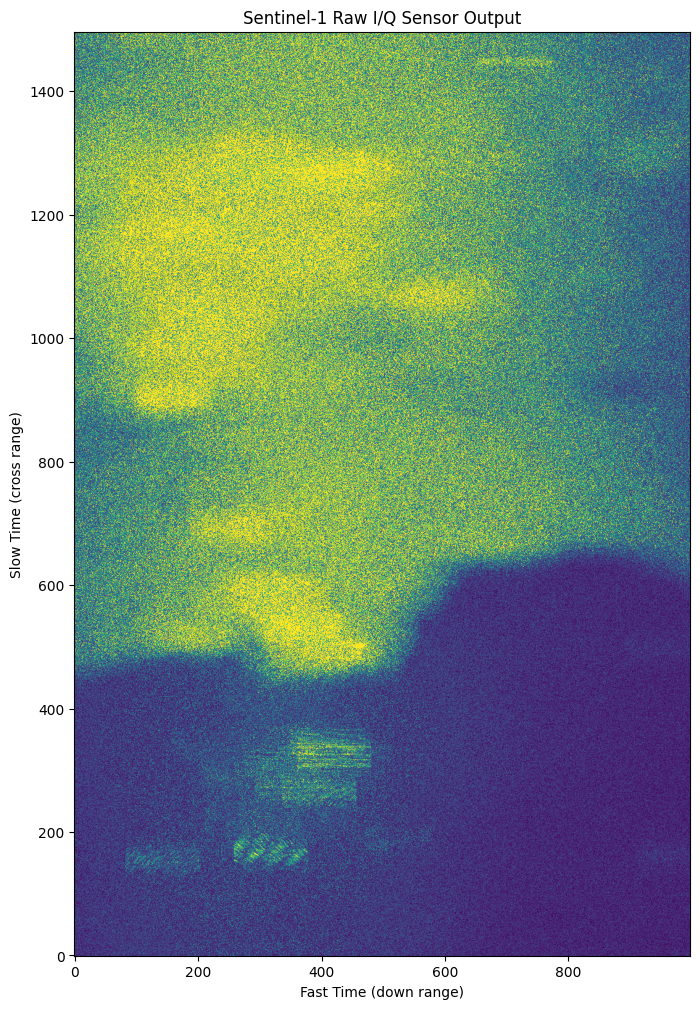

In [7]:
# Plot the raw IQ data extracted from the data file
plt.figure(figsize=(12, 12))
plt.title("Sentinel-1 Raw I/Q Sensor Output")
# We're just going to plot every 20th row/col value for speed here
plt.imshow(abs(radar_data[::20,::20]), vmin=0, vmax=15, origin='lower')
plt.xlabel("Fast Time (down range)")
plt.ylabel("Slow Time (cross range)")
plt.show()

## 4 - Image Processing

The following section demonstrates an implementation of the range-Doppler algorithm. This essentially consists of the following steps:
- Range compression
- Transform to range-Doppler domain
- Range Cell Migration Correction (RCMC)
- Azimuth compression
- Transform to time domain
- Image formation

### 4.1 - Define auxiliary parameters

We require a number of parameters in the calculations that follow, so we'll define them all here. These are:
- Image sizes
- Various transmitted pulse parameters used to synthesize a replica Tx pulse
- Sample rates in range and azimuth
- The fast time $\tau$ associated with each range sample along a range line, and the corresponding slant range of closest approach $R_{0}$ for each of these range samples
- The frequency axes in range $f_{\tau}$ and azimuth $f_{\eta}$ after transforming our array to the frequency domain
- The effective spacecraft velocity $V_{r}$. This is a psuedo velocity approximated by $V_{r} \approx \sqrt{V_{s} V_{g}}$, where $V_{s}$ is the norm of the satellite velocity vector, and $V_{g}$ is the antenna beam velocity projected onto the ground. $V_{g}$ is calculated numerically acording to the method defined in https://iopscience.iop.org/article/10.1088/1757-899X/1172/1/012012/pdf. Note that $V_{g}$ and hence $V_{r}$ varies by slant range.


In [8]:
# Image sizes
len_range_line = radar_data.shape[1]
len_az_line = radar_data.shape[0]

# Tx pulse parameters
c = sentinel1decoder.constants.SPEED_OF_LIGHT_MPS
RGDEC = selection["Range Decimation"].unique()[0]
PRI = selection["PRI"].unique()[0]
rank = selection["Rank"].unique()[0]
suppressed_data_time = 320/(8*sentinel1decoder.constants.F_REF)
range_start_time = selection["SWST"].unique()[0] + suppressed_data_time
wavelength_m = sentinel1decoder.constants.TX_WAVELENGTH_M

# Sample rates
range_sample_freq = sentinel1decoder.utilities.range_dec_to_sample_rate(RGDEC)
range_sample_period = 1/range_sample_freq
az_sample_freq = 1 / PRI
az_sample_period = PRI

# Fast time vector - defines the time axis along the fast time direction
sample_num_along_range_line = np.arange(0, len_range_line, 1)
fast_time_vec = range_start_time + (range_sample_period * sample_num_along_range_line)

# Slant range vector - defines R0, the range of closest approach, for each range cell
slant_range_vec_m = ((rank * PRI) + fast_time_vec) * c/2
    
# Axes - defines the frequency axes in each direction after FFT
az_freq_vals_hz = np.arange(-az_sample_freq/2, az_sample_freq/2, 1/(PRI*len_az_line))
 
# Spacecraft velocity - numerical calculation of the effective spacecraft velocity
ecef_vels = l0file.ephemeris.apply(lambda x: math.sqrt(x["X-axis velocity ECEF"]**2 + x["Y-axis velocity ECEF"]**2 +x["Z-axis velocity ECEF"]**2), axis=1)
velocity_interp = interp1d(l0file.ephemeris["POD Solution Data Timestamp"].unique(), ecef_vels.unique(), fill_value="extrapolate")
space_velocities_mps = selection.apply(lambda x: velocity_interp(x["Coarse Time"] + x["Fine Time"]), axis=1).to_numpy().astype(float)

# Calculate required FFT size for linear convolution in range compression
# This ensures N >= L + M - 1, where L is signal length and M is filter length
TXPL = selection["Tx Pulse Length"].unique()[0]
num_tx_vals = int(TXPL*range_sample_freq)
required_fft_size = len_range_line + num_tx_vals - 1
# Round up to next power of 2 for FFT efficiency
range_fft_size = int(2**np.ceil(np.log2(required_fft_size)))

# Delete arrays we no longer need
del velocity_interp
del ecef_vels
gc.collect()

3171

We also need the cosine of the instantaneous squint angle $D(f_{\eta}, V_{r})$, where

$$D(f_{\eta}, V_{r}) = \sqrt{1 - \frac{c^{2} f_{\eta}^{2}}{4 V_{r}^{2} f_{0}^{2}}}$$

This varies with both azimuth and range, and as such is a two dimensional array the same size as our radar data array. For the data we're working with, this is larger than 20000 x 20000 samples, and as such would consume quite a lot of computer memory if we were to simply define it as a variable - we're already holding one array of this size in memory.

Instead, we're going to define an iterator which will return smaller chunks of the array, thereby only keeping more managable chunks of data in memory at one time. This is purely a programming trick, and isn't required for the math - if your computer can handle it, you might see a small performance bump by precomputing this array and using it directly instead.

In [9]:

# The ephemeris is provided at a much lower rate than the rate we receive packets
# Therefore, we're using interpolation to get the spacecraft position along the azimuth axis
x_interp = interp1d(l0file.ephemeris["POD Solution Data Timestamp"].unique(), l0file.ephemeris["X-axis position ECEF"].unique(), fill_value="extrapolate")
y_interp = interp1d(l0file.ephemeris["POD Solution Data Timestamp"].unique(), l0file.ephemeris["Y-axis position ECEF"].unique(), fill_value="extrapolate")
z_interp = interp1d(l0file.ephemeris["POD Solution Data Timestamp"].unique(), l0file.ephemeris["Z-axis position ECEF"].unique(), fill_value="extrapolate")
x_positions = selection.apply(lambda x: x_interp(x["Coarse Time"] + x["Fine Time"]), axis=1).to_numpy().astype(float)
y_positions = selection.apply(lambda x: y_interp(x["Coarse Time"] + x["Fine Time"]), axis=1).to_numpy().astype(float)
z_positions = selection.apply(lambda x: z_interp(x["Coarse Time"] + x["Fine Time"]), axis=1).to_numpy().astype(float)
position_array = np.transpose(np.vstack((x_positions, y_positions, z_positions)))

wgs84_semi_major_axis_m = sentinel1decoder.constants.WGS84_SEMI_MAJOR_AXIS_M
wgs84_semi_minor_axis_m = sentinel1decoder.constants.WGS84_SEMI_MINOR_AXIS_M
satellite_distance_from_center_m = np.linalg.norm(position_array, axis=1)
satellite_angular_velocity_rps = np.divide(space_velocities_mps, satellite_distance_from_center_m)
satellite_latitude_rad = np.arctan(np.divide(position_array[:, 2], position_array[:, 0]))
local_earth_rad_m = np.sqrt(
    np.divide(
        (np.square(wgs84_semi_major_axis_m**2 * np.cos(satellite_latitude_rad)) + np.square(wgs84_semi_minor_axis_m**2 * np.sin(satellite_latitude_rad))),
        (np.square(wgs84_semi_major_axis_m * np.cos(satellite_latitude_rad)) + np.square(wgs84_semi_minor_axis_m * np.sin(satellite_latitude_rad)))
    )
)

# Delete variables we no longer need
del x_interp
del y_interp
del z_interp
del satellite_angular_velocity_rps
del satellite_latitude_rad
del position_array
del x_positions
del y_positions
del z_positions
gc.collect()

def compute_D_chunks(local_earth_rad_m, satellite_distance_from_center_m, space_velocities_mps, slant_range_vec_m, 
                     az_freq_vals_hz, wavelength_m, chunk_size=512):
    """
    Generator that yields chunks of D on demand.
    Each chunk computes intermediate arrays only for that chunk's rows.
    This avoids storing the full 2D D array in memory.
    
    Yields:
        (start_idx, end_idx, D_chunk) tuples where:
        - start_idx, end_idx: slice indices for this chunk
        - D_chunk: 2D array of D values for this chunk, shape (chunk_size, len_range_line)
    """
    len_az_line = len(local_earth_rad_m)
    
    for start_idx in range(0, len_az_line, chunk_size):
        end_idx = min(start_idx + chunk_size, len_az_line)
        
        # Extract chunk of 1D arrays
        local_earth_rad_chunk_m = local_earth_rad_m[start_idx:end_idx]
        satellite_distance_chunk_m = satellite_distance_from_center_m[start_idx:end_idx]
        space_velocities_chunk_mps = space_velocities_mps[start_idx:end_idx]
        az_freq_vals_chunk_hz = az_freq_vals_hz[start_idx:end_idx]
        
        # Compute angular velocity for this chunk (angular_velocity = space_velocities / distance_from_center)
        satellite_angular_velocity_chunk_rps = np.divide(space_velocities_chunk_mps, satellite_distance_chunk_m)
        
        # Compute 2D intermediate arrays for this chunk only
        cos_beta_chunk = (np.divide(
            np.square(local_earth_rad_chunk_m[:, np.newaxis]) + 
            np.square(satellite_distance_chunk_m[:, np.newaxis]) - 
            np.square(slant_range_vec_m), 
            2 * local_earth_rad_chunk_m[:, np.newaxis] * satellite_distance_chunk_m[:, np.newaxis]
        ))
        ground_velocities_chunk_mps = (local_earth_rad_chunk_m[:, np.newaxis] * 
                                   satellite_angular_velocity_chunk_rps[:, np.newaxis] * cos_beta_chunk)
        effective_velocities_chunk_mps = np.sqrt(space_velocities_chunk_mps[:, np.newaxis] * 
                                            ground_velocities_chunk_mps)
        
        # Compute D chunk
        D_chunk = np.sqrt(1 - np.divide(
            wavelength_m**2 * np.square(az_freq_vals_chunk_hz[:, np.newaxis]),
            4 * np.square(effective_velocities_chunk_mps)
        ))
        
        yield start_idx, end_idx, D_chunk
        # Chunk is automatically garbage collected after yield

### 4.2 - Convert data to 2D frequency domain

We're going to be doing almost all our calculations in the frequency domain, so the first step is to FFT along the azimuth and range axes.

In [10]:
# Zero-pad along range axis to enable linear convolution
radar_data = np.pad(radar_data, ((0, 0), (0, range_fft_size - len_range_line)), mode='constant', constant_values=0)

# FFT each range line with explicit size for linear convolution
radar_data = fft(radar_data, n=range_fft_size, axis=1, overwrite_x=True)

# FFT each azimuth line
radar_data = fftshift(fft(radar_data, axis=0, overwrite_x=True), axes=0)

assert radar_data.dtype == np.complex64

### 4.3 - Range compression - create and apply matched filter

Range compression is relatively simple. Range information is encoded in the arrival time of the pulse echo (i.e. an echo from a target further away will take longer to arrive), so by applying a matched filter consisting of the transmitted pulse, we can effectively focus the image along the range axis.

We can synthesize a replica of the Tx pulse from parameters specified in the packet metadata. Since we're operating in the frequency domain, we also need to transform our pulse replica that we're using as a matched filter to the frequency domain, then take the complex conjugate. Finally, we need to multiply every range line by our matched filter.

The Tx pulse replica is given by

$$\text{Tx Pulse} = exp\biggl\{2i\pi\Bigl(\bigl(\text{TXPSF} + \frac{\text{TXPRR  TXPL}}{2}\bigl)\tau + \frac{\text{TXPRR}}{2}\tau^{2}\Bigl)\biggl\}$$

where $\text{TXPSF}$ is the Tx Pulse Start Frequency, $\text{TXPRR}$ is the Tx Pulse Ramp Rate, and $\text{TXPL}$ is the Tx Pulse Length.

In [11]:
# Create replica pulse
TXPSF = selection["Tx Pulse Start Frequency"].unique()[0]
TXPRR = selection["Tx Ramp Rate"].unique()[0]
TXPL = selection["Tx Pulse Length"].unique()[0]
num_tx_vals = int(TXPL*range_sample_freq)
tx_replica_time_vals = np.linspace(-TXPL/2, TXPL/2, num=num_tx_vals)
phi1 = TXPSF + TXPRR*TXPL/2
phi2 = TXPRR/2
tx_replica = np.exp(2.0j * np.pi * (phi1*tx_replica_time_vals + phi2*tx_replica_time_vals**2)).astype(np.complex64)

# Create range filter from replica pulse, padded to range_fft_size for linear convolution
range_filter = np.zeros(range_fft_size, dtype=np.complex64)
index_start = np.ceil((range_fft_size-num_tx_vals)/2)-1
index_end = num_tx_vals+np.ceil((range_fft_size-num_tx_vals)/2)-2
range_filter[int(index_start):int(index_end+1)] = tx_replica
range_filter = np.conjugate(fft(range_filter, n=range_fft_size, overwrite_x=True))

# Apply filter
radar_data = np.multiply(radar_data, range_filter)

del range_filter
del tx_replica
gc.collect()

assert radar_data.dtype == np.complex64

### 4.4 - Range cell migration correction

Since the collector motion couples range and azimuth information, point targets will tend to produce returns spread in arcs across multiple range bins as the azimuth varies. We therefore need to apply a shift to align the phase history associated with each pointlike target into a single range bin, so we can then operate 1-dimensionally along the azimuth axis to perform azimuth compresison.

The RCMC shift is defined by

$$\text{RCMC shift} = R_{0} \biggl(\frac{1}{D} - 1\biggl)$$

with $D$ being the cosine of the instantaneous squint angle and $R_{0}$ the range of closest approach, both defined in section 4.1. Since we're still operating in the frequency domain we need to apply a filter of the form

$$\text{RCMC filter} = exp\biggl\{4i\pi\frac{f_{\tau}}{c}\bigl(\text{RCMC shift}\bigl)\biggl\}$$

Again, this needs to be multiplied by every range line in our data.

In [12]:
# Create frequency axis for RCMC (corresponding to original range samples only)
range_freq_vals_hz_rcmc = np.linspace(-range_sample_freq/2, range_sample_freq/2, num=len_range_line)

# Process RCMC filter in chunks to avoid storing full D array
for start_idx, end_idx, D_chunk in compute_D_chunks(local_earth_rad_m, satellite_distance_from_center_m, space_velocities_mps, 
                                                     slant_range_vec_m, az_freq_vals_hz, wavelength_m):
    # Compute RCMC filter for this chunk (using frequency axis matching original range samples)
    rcmc_shift_chunk_m = slant_range_vec_m[0] * (np.divide(1, D_chunk) - 1)
    # rcmc_shift_chunk_m shape: (chunk_size, len_range_line)
    # range_freq_vals_hz_rcmc shape: (len_range_line,)
    # We need to broadcast: (len_range_line,) * (chunk_size, len_range_line) -> (chunk_size, len_range_line)
    rcmc_filter_chunk = np.exp(4.0j * np.pi * range_freq_vals_hz_rcmc[np.newaxis, :] * rcmc_shift_chunk_m / c).astype(np.complex64)
    
    # Pad RCMC filter to match padded frequency domain size (fill with 1.0 for padded bins)
    rcmc_filter_chunk_padded = np.ones((rcmc_filter_chunk.shape[0], range_fft_size), dtype=np.complex64)
    rcmc_filter_chunk_padded[:, :len_range_line] = rcmc_filter_chunk
    
    # Apply RCMC filter to this chunk
    radar_data[start_idx:end_idx, :] *= rcmc_filter_chunk_padded

del D_chunk
del rcmc_filter_chunk
del rcmc_filter_chunk_padded
del range_freq_vals_hz_rcmc
gc.collect()

assert radar_data.dtype == np.complex64

### 4.5 - Convert to range-Doppler domain

We've finished processing the image in range, so we can inverse FFT back to the range domain along the range axis. The image will still be in the frequency domain in azimuth.

In [13]:
radar_data = ifftshift(ifft(radar_data, axis=1, overwrite_x=True), axes=1)

# Truncate back to original range line length after linear convolution
radar_data = radar_data[:, :len_range_line]

assert radar_data.dtype == np.complex64

### 4.6 - Azimuth compression - create and apply matched filter

Our azimuth filter is defined by

$$\text{Azimuth filter} = exp\biggl\{4i\pi\frac{R_{0}D(f_{\eta}, V_{r})}{\lambda}\biggl\}$$

In [14]:
# Process azimuth filter in chunks to avoid storing full D array
for start_idx, end_idx, D_chunk in compute_D_chunks(local_earth_rad_m, satellite_distance_from_center_m, space_velocities_mps, 
                                                     slant_range_vec_m, az_freq_vals_hz, wavelength_m):
    # Compute azimuth filter for this chunk
    az_filter_chunk = np.exp(4.0j * np.pi * slant_range_vec_m * D_chunk / wavelength_m).astype(np.complex64)
    
    # Apply filter to this chunk
    radar_data[start_idx:end_idx, :] *= az_filter_chunk

# Clean up arrays we no longer need
del D_chunk
del az_filter_chunk
del local_earth_rad_m
del satellite_distance_from_center_m
del space_velocities_mps
del slant_range_vec_m
del az_freq_vals_hz
del fast_time_vec
gc.collect()

assert radar_data.dtype == np.complex64

### 4.7 - Transform back to range-azimuth domain

Finally, we'll transform back out of the frequency domain by taking the inverse FFT of each azimuth line.

In [15]:
radar_data = ifft(radar_data, axis=0, overwrite_x=True)

assert radar_data.dtype == np.complex64

## 5 - Plot Results

With azimuth compression complete, we're ready to plot our image!

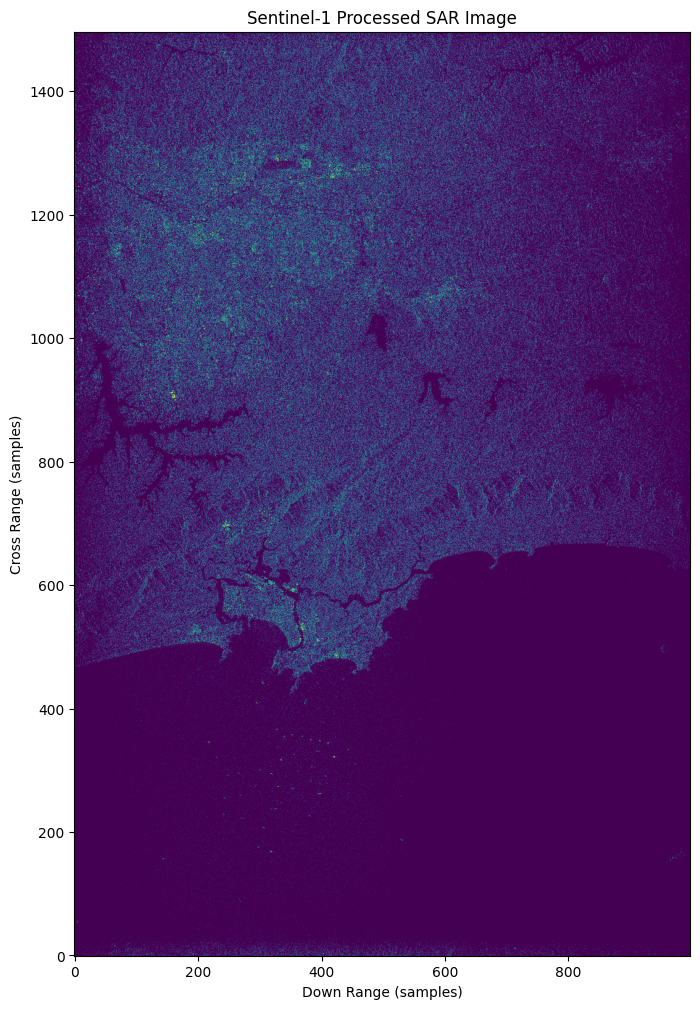

In [16]:
# Plot final image
plt.figure(figsize=(12, 12))
plt.title("Sentinel-1 Processed SAR Image")
plt.imshow(abs(radar_data[::20, ::20]), origin='lower', norm=colors.LogNorm(vmin=300, vmax=10000))
plt.xlabel("Down Range (samples)")
plt.ylabel("Cross Range (samples)")
plt.show()

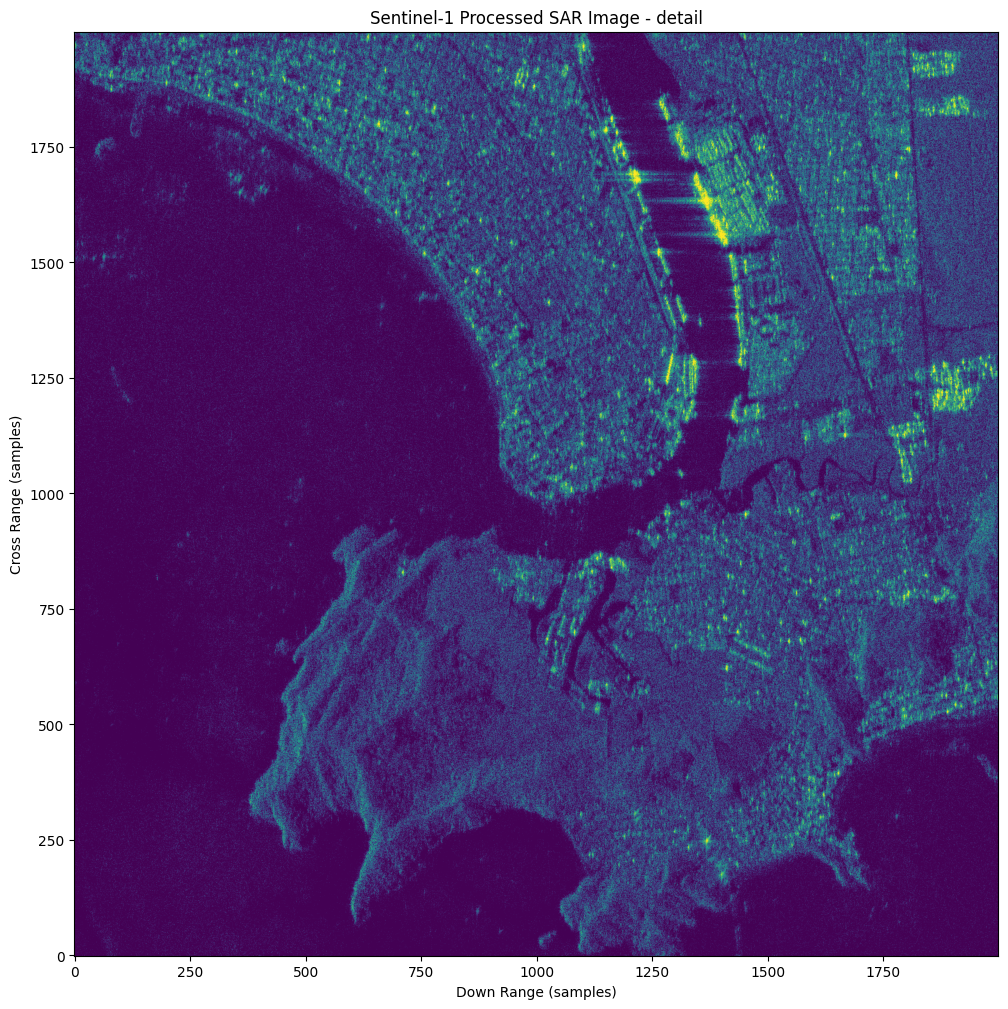

In [17]:
# Plot final image - detail
plt.figure(figsize=(12, 12))
plt.title("Sentinel-1 Processed SAR Image - detail")
plt.imshow(abs(radar_data[9000:11000, 6000:8000]), origin='lower', norm=colors.LogNorm(vmin=300, vmax=10000))
plt.xlabel("Down Range (samples)")
plt.ylabel("Cross Range (samples)")
plt.show()

There are still a few noteworthy issues with our image. Various terrain features are clearly visible, however the image is still not perfectly focused. We have assumed a Doppler centroid of 0Hz, and have not applied a number of additional processing steps that ESA use to produce Level 1 products e.g. Secondary Range Compression (SRC). These are left as an exercise for the reader.